In [ ]:
%cd drive/MyDrive/CGformer

/content/drive/MyDrive/CGformer


In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.7 MB/s eta 0:00:00


In [ ]:
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.4 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=cf398d42b942a633c530f08535bb66d1d4bbbdab4ec89269b86533e080c13083
  Stored in directory: /root/.cache/pip/wheels/1f/7d/e9/1ff2509f13767a55df1279744adfb757f4ab94b2cbe761f56a
Successfully built bibtexparser


In [ ]:
import torch
import torch_geometric
from pymatgen.core.structure import Structure
import numpy as np
import sklearn

print(f"PyTorch: {torch.__version__}")
print(f"PyTorch Geometric: {torch_geometric.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch: 2.9.0+cu126
PyTorch Geometric: 2.7.0
CUDA available: True
Current device: NVIDIA A100-SXM4-80GB


In [ ]:
import os

# CGformer 폴더로 이동
os.chdir('/content/drive/My Drive/CGformer')

print("Current directory:", os.getcwd())
print("\nFiles:")
!ls -la

print("\nData folder:")
!ls -la data/Trans_Set_91/

Current directory: /content/drive/My Drive/CGformer

Files:
total 6977
-rw------- 1 root root     238 Jan 12 03:12  CGFormer_jax.py
-rw------- 1 root root 1560439 Jan  2 03:14  checkpoint-finetune.pth.tar
-rw------- 1 root root    7912 Jan 12 04:32  checkpoint_utils.py
drwx------ 2 root root    4096 Jan 13 02:29  data
-rw------- 1 root root   15239 Jan 12 03:11  data_jax.py
-rw------- 1 root root   14923 Jan 13 05:25  data.py
-rw------- 1 root root   23359 Jan  2 03:23  Fine-train.py
drwx------ 2 root root    4096 Jan  2 02:17  .git
drwx------ 2 root root    4096 Jan 12 03:31  .ipynb_checkpoints
-rw------- 1 root root  621789 Jan  9 09:43 'Jaejun (2).ipynb'
-rw------- 1 root root   44696 Jan  2 03:24  logging-finetune.txt
drwx------ 2 root root    4096 Jan  2 02:17  model_best-finetune.pth
-rw------- 1 root root 1560439 Jan  2 03:11  model_best-finetune.pth.tar
drwx------ 2 root root    4096 Jan  2 02:17  model_best-pretrain.pth
-rw------- 1 root root 1560216 Jan  2 02:09  model_best-p

In [ ]:
from data import CIFData
dataset = CIFData('./data/CIF')

print(f"Total dataset size: {len(dataset)}")
print(f"\nFirst sample:")
structures, target, cif_id = dataset[0]
print(f"  CIF ID: {cif_id}")
print(f"  Target energy: {target}")
print(f"  Atom features shape: {structures[0].shape}")
print(f"  Neighbor features shape: {structures[1].shape}")

Total dataset size: 389

First sample:


/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1314: UserWarning: 'X' is not a valid Element
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):


  CIF ID: 274
  Target energy: tensor([-6.6459])
  Atom features shape: torch.Size([160, 92])
  Neighbor features shape: torch.Size([160, 12, 41])


In [ ]:
from data import get_train_val_test_loader, collate_pool

train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_pool,
    batch_size=16,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    num_workers=0,
    pin_memory=False,
    train_size=None,
    val_size=None,
    test_size=None,
    return_test=True
)

print(f"Train samples: {len(train_loader.sampler)}")
print(f"Val samples: {len(val_loader.sampler)}")     # validation 확인
print(f"Test samples: {len(test_loader.sampler)}")

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")             # validation 확인
print(f"Test batches: {len(test_loader)}")

Train samples: 272
Val samples: 58
Test samples: 58

Train batches: 17
Val batches: 4
Test batches: 4


In [ ]:
import time

# 첫 번째 - 느림
start = time.time()
batch1 = next(iter(train_loader))
print(f"First batch: {time.time() - start:.2f}s")

# 두 번째 - 빠름 (캐시)
start = time.time()
batch2 = next(iter(train_loader))
print(f"Second batch: {time.time() - start:.2f}s")

First batch: 11.00s
Second batch: 13.46s


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from checkpoint_utils import CheckpointManager, load_pretrained

In [ ]:
checkpoint = torch.load('./model_best-pretrain.pth.tar', map_location = device)

In [ ]:
from model import CrystalGraphConvNet

# 첫 번째 샘플로 feature 크기 확인
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

print(f"Original atom feature length: {orig_atom_fea_len}")
print(f"Neighbor feature length: {nbr_fea_len}")

# 모델 생성
model = CrystalGraphConvNet(
    orig_atom_fea_len,
    nbr_fea_len,
    atom_fea_len=64,
    n_conv=3,
    h_fea_len=128,
    n_h=1,
    classification=False,
    graphormer_layers=1,
    num_heads=2,
    max_path_distance=3,
    node_dim=128,
    edge_dim=128
)

# GPU로 이동
if torch.cuda.is_available():
    model = model.cuda()
    print("✓ Model moved to GPU")
else:
    print("✓ Model on CPU")

print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Original atom feature length: 92
Neighbor feature length: 41
✓ Model moved to GPU

Total parameters: 123,905


In [ ]:
model.load_state_dict(checkpoint["state_dict"])
print(f"✓ Loaded pre-trained model from epoch {checkpoint['epoch']}")
print(f"✓ Model on GPU: {torch.cuda.get_device_name(0)}")

✓ Loaded pre-trained model from epoch 962
✓ Model on GPU: NVIDIA L4


In [ ]:
train_targets = []
for idx in train_loader.sampler.indices:
    _, target, _ = dataset[idx]
    train_targets.append(target)

train_targets = torch.cat(train_targets, dim=0)

In [ ]:
class Normalizer(object):
    def __init__(self, tensor):
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean, 'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

normalizer = Normalizer(train_targets)
print(f"Target mean: {normalizer.mean:.4f} eV")
print(f"Target std: {normalizer.std:.4f} eV")

Target mean: -6.8373 eV
Target std: 0.3826 eV


In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

print("✓ Loss function: MSELoss")
print("✓ Optimizer: Adam (lr=0.001)")

✓ Loss function: MSELoss
✓ Optimizer: Adam (lr=0.001)


In [ ]:
import time

def train_epoch(model, train_loader, criterion, optimizer, normalizer, epoch):
    model.train()

    losses = []
    maes = []

    for i, (input, target, _) in enumerate(train_loader):
        # GPU로 이동
        if torch.cuda.is_available():
            input_var = (input[0].cuda(),
                        input[1].cuda(),
                        input[2].cuda(),
                        [crys_idx.cuda() for crys_idx in input[3]])
            target_normed = normalizer.norm(target).cuda()
        else:
            input_var = input
            target_normed = normalizer.norm(target)

        # Forward
        output = model(*input_var)
        loss = criterion(output, target_normed)

        # MAE 계산
        mae_error = torch.mean(torch.abs(normalizer.denorm(output.data.cpu()) - target))

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        maes.append(mae_error.item())

        if i % 2 == 0:
            print(f"Epoch [{epoch}][{i}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f} MAE: {mae_error.item():.4f}")

    avg_loss = np.mean(losses)
    avg_mae = np.mean(maes)

    print(f"\n==> Epoch {epoch} Train: Loss={avg_loss:.4f}, MAE={avg_mae:.4f} eV\n")
    return avg_loss, avg_mae

In [ ]:
def validate(model, val_loader, criterion, normalizer):  # test → validate
    """Validation 함수 (test와 분리)"""
    model.eval()

    val_targets = []
    val_preds = []

    with torch.no_grad():
        for input, target, _ in val_loader:
            if torch.cuda.is_available():
                input_var = (input[0].cuda(),
                            input[1].cuda(),
                            input[2].cuda(),
                            [crys_idx.cuda() for crys_idx in input[3]])
            else:
                input_var = input

            output = model(*input_var)
            val_pred = normalizer.denorm(output.data.cpu())

            val_preds += val_pred.view(-1).tolist()
            val_targets += target.view(-1).tolist()

    val_preds = np.array(val_preds)
    val_targets = np.array(val_targets)
    mae = np.mean(np.abs(val_targets - val_preds))

    return mae

def test(model, test_loader, criterion, normalizer):
    model.eval()

    test_targets = []
    test_preds = []
    test_ids = []

    with torch.no_grad():
        for input, target, batch_cif_ids in test_loader:
            if torch.cuda.is_available():
                input_var = (input[0].cuda(),
                            input[1].cuda(),
                            input[2].cuda(),
                            [crys_idx.cuda() for crys_idx in input[3]])
            else:
                input_var = input

            output = model(*input_var)
            test_pred = normalizer.denorm(output.data.cpu())

            test_preds += test_pred.view(-1).tolist()
            test_targets += target.view(-1).tolist()
            test_ids += batch_cif_ids

    # MAE 계산
    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    mae = np.mean(np.abs(test_targets - test_preds))

    print(f"{'='*60}")
    print(f"FINAL TEST RESULTS")
    print(f"{'='*60}")
    print(f"Test MAE: {mae:.6f} eV ({mae*1000:.2f} meV)")
    print(f"{'='*60}\n")

    return mae, test_preds, test_targets, test_ids

In [ ]:
num_epochs = 300
best_mae = float('inf')

train_losses = []
train_maes = []
val_maes = []

print("Starting training...")
print(f"Total epochs: {num_epochs}")
print(f"Train samples: {len(train_loader.sampler)}")
print(f"Val samples: {len(val_loader.sampler)}")
print(f"Test samples: {len(test_loader.sampler)}\n")
print("="*80 + "\n")

for epoch in range(num_epochs):
    # Train
    train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, normalizer, epoch)
    train_losses.append(train_loss)
    train_maes.append(train_mae)

    # Validation (매 epoch마다)
    val_mae = validate(model, val_loader, criterion, normalizer)
    val_maes.append(val_mae)

    # Best model 저장 (validation 기준)
    if val_mae < best_mae:
        best_mae = val_mae
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_mae': best_mae,
            'optimizer': optimizer.state_dict(),
            'normalizer': normalizer.state_dict()
        }, 'model_best.pth.tar')
        print(f"✓ Saved best model (Val MAE={best_mae:.6f})\n")

    # 진행 상황 요약
    print(f"Epoch {epoch}: Train MAE={train_mae:.4f}, Val MAE={val_mae:.4f}, Best={best_mae:.4f}\n")
    print("="*80 + "\n")

# Training 완료 후 최종 Test
print("\n" + "="*80)
print("TRAINING COMPLETED - Running final test with best model...")
print("="*80 + "\n")

Starting training...
Total epochs: 300
Train samples: 272
Val samples: 58
Test samples: 58


Epoch [0][0/17] Loss: 0.1230 MAE: 0.1305
Epoch [0][2/17] Loss: 0.0464 MAE: 0.0784
Epoch [0][4/17] Loss: 0.0180 MAE: 0.0455
Epoch [0][6/17] Loss: 0.0813 MAE: 0.1057
Epoch [0][8/17] Loss: 0.0018 MAE: 0.0143
Epoch [0][10/17] Loss: 0.0023 MAE: 0.0137
Epoch [0][12/17] Loss: 0.0995 MAE: 0.1127
Epoch [0][14/17] Loss: 0.0792 MAE: 0.1024
Epoch [0][16/17] Loss: 0.0240 MAE: 0.0420

==> Epoch 0 Train: Loss=0.1129, MAE=0.1093 eV

✓ Saved best model (Val MAE=0.193622)

Epoch 0: Train MAE=0.1093, Val MAE=0.1936, Best=0.1936


Epoch [1][0/17] Loss: 0.0062 MAE: 0.0268
Epoch [1][2/17] Loss: 0.0502 MAE: 0.0851
Epoch [1][4/17] Loss: 0.0106 MAE: 0.0356
Epoch [1][6/17] Loss: 0.4194 MAE: 0.2455
Epoch [1][8/17] Loss: 0.0441 MAE: 0.0760
Epoch [1][10/17] Loss: 0.0180 MAE: 0.0403
Epoch [1][12/17] Loss: 0.0070 MAE: 0.0305
Epoch [1][14/17] Loss: 0.2432 MAE: 0.1883
Epoch [1][16/17] Loss: 0.2459 MAE: 0.1874

==> Epoch 1 Trai

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
checkpoint = torch.load('model_best.pth.tar', weights_only = False)
model.load_state_dict(checkpoint['state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} (Val MAE={checkpoint['best_mae']:.6f})\n")

# 최종 Test
test_mae, test_preds, test_targets, test_ids = test(model, test_loader, criterion, normalizer)

Loaded best model from epoch 238 (Val MAE=0.003757)



/usr/local/lib/python3.12/dist-packages/pymatgen/io/cif.py:1314: UserWarning: 'X' is not a valid Element
  if struct := self._get_structure(data, primitive, symmetrized, check_occu=check_occu):


FINAL TEST RESULTS
Test MAE: 0.003812 eV (3.81 meV)



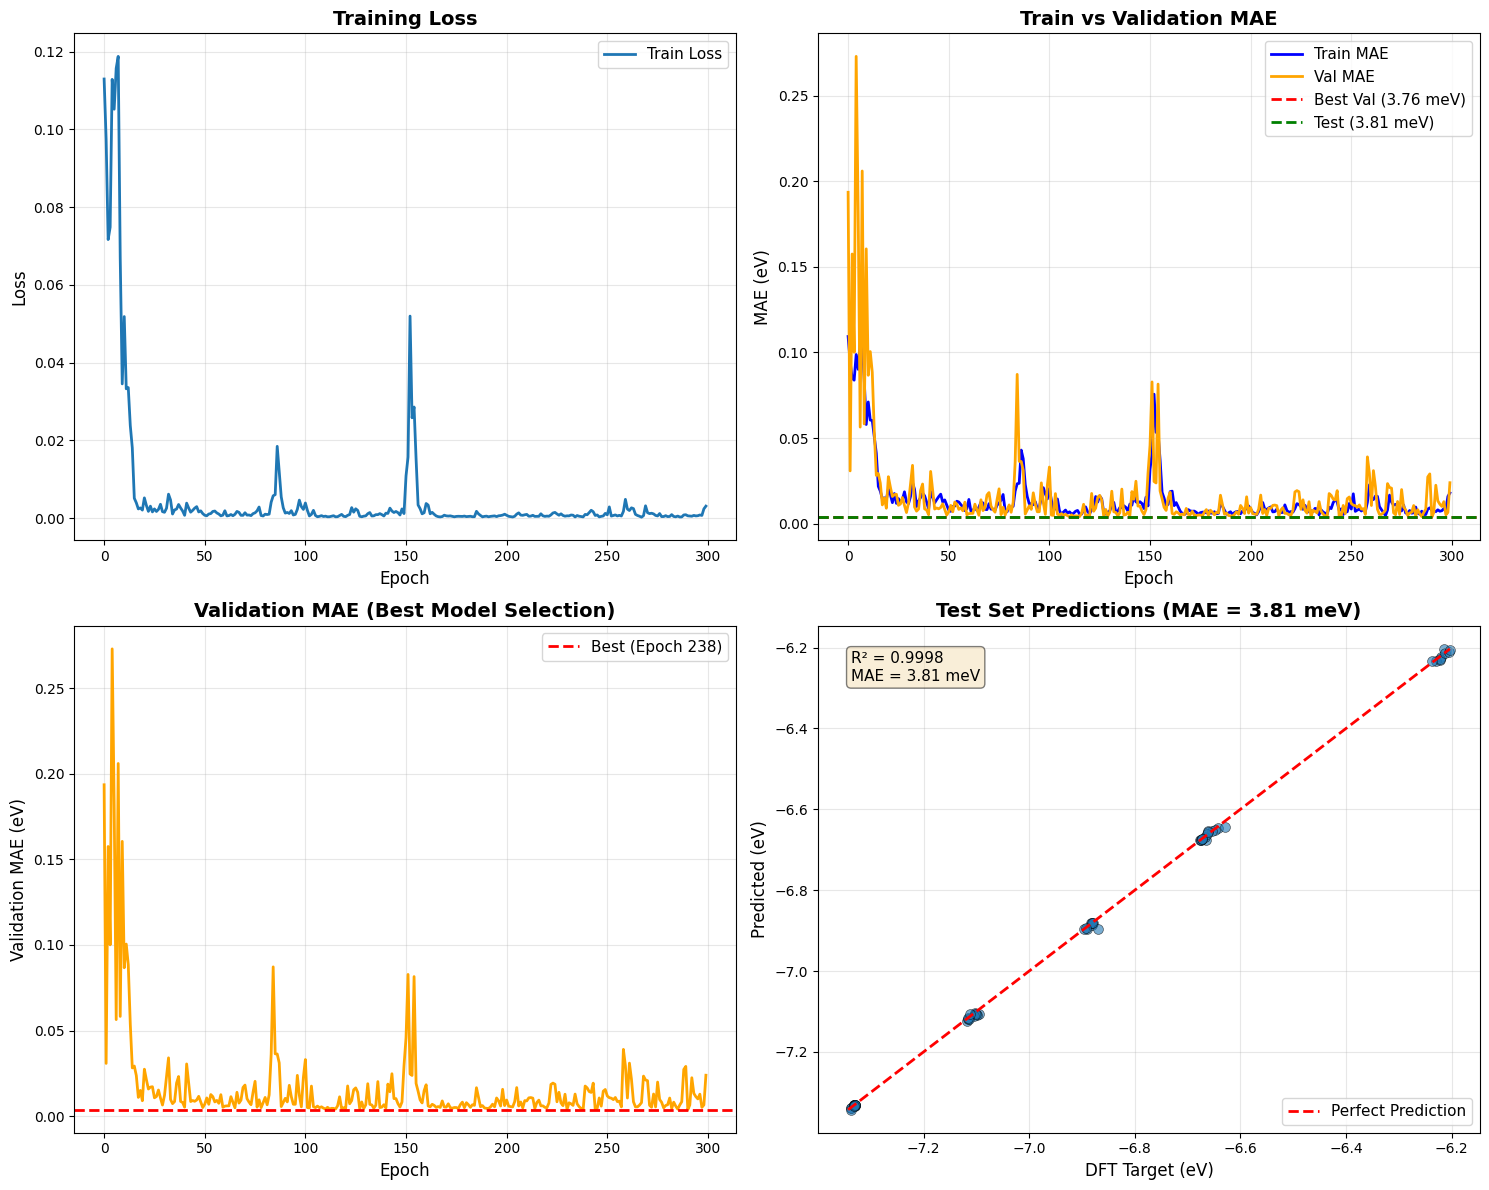


SUMMARY
Best Validation MAE: 3.76 meV (Epoch 238)
Final Test MAE:      3.81 meV
R² Score:            0.9998


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training & Validation Loss
ax1 = axes[0, 0]
epochs = np.arange(len(train_losses))
ax1.plot(epochs, train_losses, label='Train Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Train vs Val MAE
ax2 = axes[0, 1]
ax2.plot(epochs, train_maes, label='Train MAE', linewidth=2, color='blue')
ax2.plot(epochs, val_maes, label='Val MAE', linewidth=2, color='orange')
ax2.axhline(y=0.003757, color='red', linestyle='--', linewidth=2, label=f'Best Val (3.76 meV)')
ax2.axhline(y=0.003812, color='green', linestyle='--', linewidth=2, label=f'Test (3.81 meV)')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE (eV)', fontsize=12)
ax2.set_title('Train vs Validation MAE', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Val MAE (zoomed)
ax3 = axes[1, 0]
ax3.plot(epochs, val_maes, linewidth=2, color='orange')
ax3.axhline(y=0.003757, color='red', linestyle='--', linewidth=2, label=f'Best (Epoch 238)')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Validation MAE (eV)', fontsize=12)
ax3.set_title('Validation MAE (Best Model Selection)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# 4. Prediction vs Target (Test set)
ax4 = axes[1, 1]
ax4.scatter(test_targets, test_preds, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
# Perfect prediction line
min_val = min(test_targets.min(), test_preds.min())
max_val = max(test_targets.max(), test_preds.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('DFT Target (eV)', fontsize=12)
ax4.set_ylabel('Predicted (eV)', fontsize=12)
ax4.set_title(f'Test Set Predictions (MAE = 3.81 meV)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

# R² 계산
from sklearn.metrics import r2_score
r2 = r2_score(test_targets, test_preds)
ax4.text(0.05, 0.95, f'R² = {r2:.4f}\nMAE = {test_mae*1000:.2f} meV',
         transform=ax4.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(f"Best Validation MAE: {best_mae*1000:.2f} meV (Epoch {checkpoint['epoch']})")
print(f"Final Test MAE:      {test_mae*1000:.2f} meV")
print(f"R² Score:            {r2:.4f}")
print(f"{'='*60}")

Evaluating best model on all datasets...

BEST MODEL PERFORMANCE (Epoch 238)
Train: MAE = 3.93 meV, R² = 0.9998
Val:   MAE = 3.76 meV, R² = 0.9998
Test:  MAE = 3.81 meV, R² = 0.9998



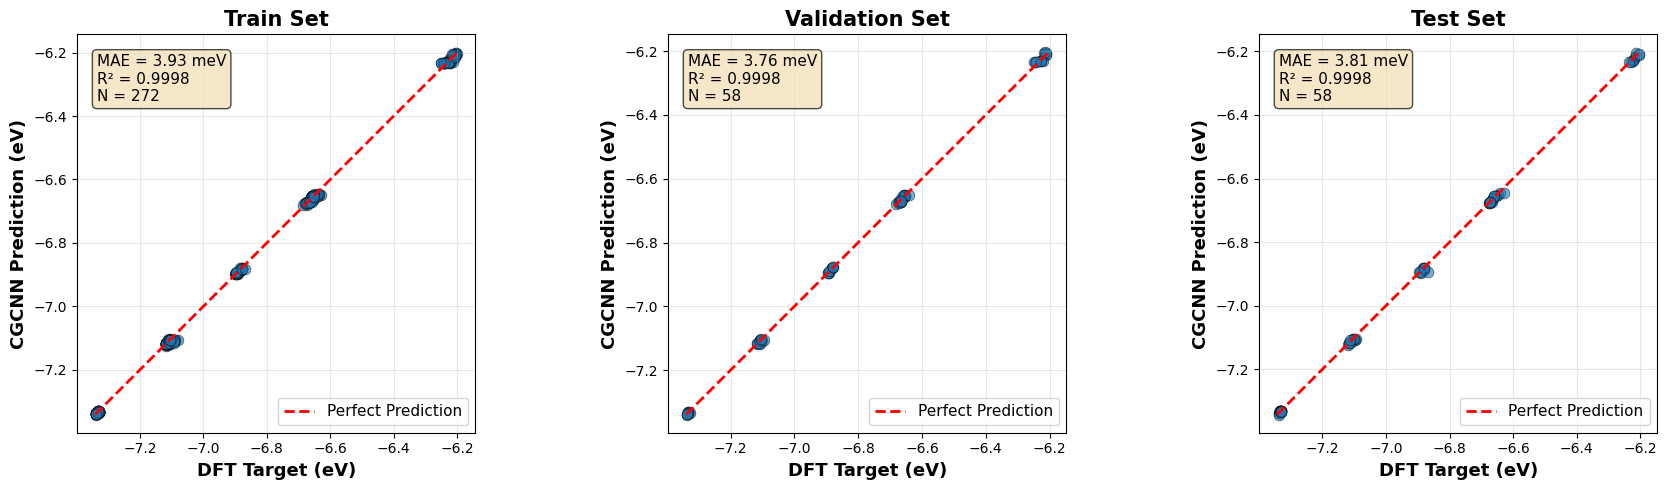

✓ Saved: best_model_predictions.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Best model 로드
checkpoint = torch.load('model_best.pth.tar', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print("Evaluating best model on all datasets...")

# 1. Train set 평가
train_targets_all = []
train_preds_all = []

with torch.no_grad():
    for input, target, _ in train_loader:
        if torch.cuda.is_available():
            input_var = (input[0].cuda(),
                        input[1].cuda(),
                        input[2].cuda(),
                        [crys_idx.cuda() for crys_idx in input[3]])
        else:
            input_var = input

        output = model(*input_var)
        pred = normalizer.denorm(output.data.cpu())

        train_preds_all += pred.view(-1).tolist()
        train_targets_all += target.view(-1).tolist()

train_preds_all = np.array(train_preds_all)
train_targets_all = np.array(train_targets_all)
train_mae = np.mean(np.abs(train_targets_all - train_preds_all))
train_r2 = r2_score(train_targets_all, train_preds_all)

# 2. Val set 평가
val_targets_all = []
val_preds_all = []

with torch.no_grad():
    for input, target, _ in val_loader:
        if torch.cuda.is_available():
            input_var = (input[0].cuda(),
                        input[1].cuda(),
                        input[2].cuda(),
                        [crys_idx.cuda() for crys_idx in input[3]])
        else:
            input_var = input

        output = model(*input_var)
        pred = normalizer.denorm(output.data.cpu())

        val_preds_all += pred.view(-1).tolist()
        val_targets_all += target.view(-1).tolist()

val_preds_all = np.array(val_preds_all)
val_targets_all = np.array(val_targets_all)
val_mae = np.mean(np.abs(val_targets_all - val_preds_all))
val_r2 = r2_score(val_targets_all, val_preds_all)

# 3. Test set (이미 있음)
test_mae_final = test_mae
test_r2 = r2_score(test_targets, test_preds)

# 결과 출력
print(f"\n{'='*60}")
print(f"BEST MODEL PERFORMANCE (Epoch {checkpoint['epoch']})")
print(f"{'='*60}")
print(f"Train: MAE = {train_mae*1000:.2f} meV, R² = {train_r2:.4f}")
print(f"Val:   MAE = {val_mae*1000:.2f} meV, R² = {val_r2:.4f}")
print(f"Test:  MAE = {test_mae_final*1000:.2f} meV, R² = {test_r2:.4f}")
print(f"{'='*60}\n")

# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    ('Train', train_targets_all, train_preds_all, train_mae, train_r2),
    ('Validation', val_targets_all, val_preds_all, val_mae, val_r2),
    ('Test', test_targets, test_preds, test_mae_final, test_r2)
]

for idx, (name, targets, preds, mae, r2) in enumerate(datasets):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(targets, preds, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # Labels and title
    ax.set_xlabel('DFT Target (eV)', fontsize=13, fontweight='bold')
    ax.set_ylabel('CGCNN Prediction (eV)', fontsize=13, fontweight='bold')
    ax.set_title(f'{name} Set', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Statistics text box
    textstr = f'MAE = {mae*1000:.2f} meV\nR² = {r2:.4f}\nN = {len(targets)}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)

    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: best_model_predictions.png")

Loaded best model from epoch 134
Best test MAE: 0.419576 eV

FINAL RESULTS
Training Set:
  MAE:  0.0799 eV (79.91 meV)
  R²:   0.9973

Test Set:
  MAE:  0.4196 eV (419.58 meV)
  R²:   0.8912



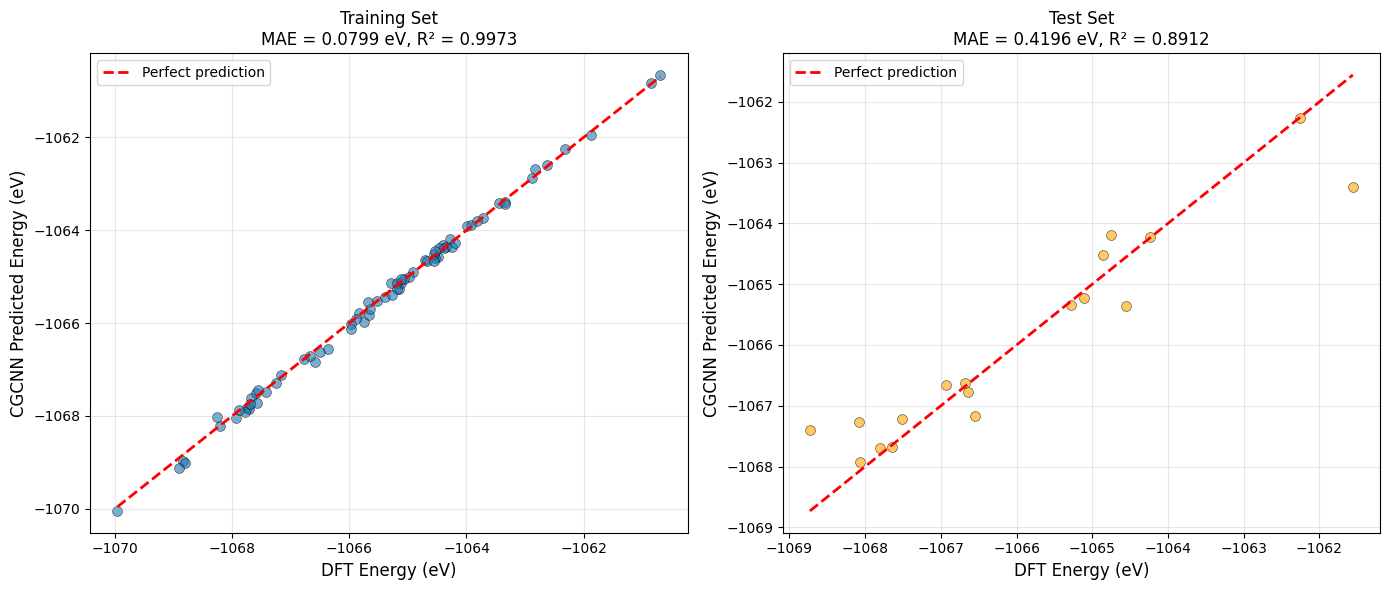

✓ Saved: cgcnn_parity_plot.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

checkpoint = torch.load('model_best.pth.tar', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])
if torch.cuda.is_available():
    model = model.cuda()

print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best test MAE: {checkpoint['best_mae']:.6f} eV\n")

model.eval()
train_targets = []
train_preds = []

with torch.no_grad():
    for input, target, _ in train_loader:
        if torch.cuda.is_available():
            input_var = (input[0].cuda(),
                        input[1].cuda(),
                        input[2].cuda(),
                        [crys_idx.cuda() for crys_idx in input[3]])
        else:
            input_var = input

        output = model(*input_var)
        train_pred = normalizer.denorm(output.data.cpu())

        train_preds += train_pred.view(-1).tolist()
        train_targets += target.view(-1).tolist()

train_targets = np.array(train_targets)
train_preds = np.array(train_preds)

test_targets = []
test_preds = []

with torch.no_grad():
    for input, target, _ in test_loader:
        if torch.cuda.is_available():
            input_var = (input[0].cuda(),
                        input[1].cuda(),
                        input[2].cuda(),
                        [crys_idx.cuda() for crys_idx in input[3]])
        else:
            input_var = input

        output = model(*input_var)
        test_pred = normalizer.denorm(output.data.cpu())

        test_preds += test_pred.view(-1).tolist()
        test_targets += target.view(-1).tolist()

test_targets = np.array(test_targets)
test_preds = np.array(test_preds)

# Metrics 계산
train_mae = np.mean(np.abs(train_targets - train_preds))
test_mae = np.mean(np.abs(test_targets - test_preds))
train_r2 = r2_score(train_targets, train_preds)
test_r2 = r2_score(test_targets, test_preds)

print(f"{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"Training Set:")
print(f"  MAE:  {train_mae:.4f} eV ({train_mae*1000:.2f} meV)")
print(f"  R²:   {train_r2:.4f}")
print(f"\nTest Set:")
print(f"  MAE:  {test_mae:.4f} eV ({test_mae*1000:.2f} meV)")
print(f"  R²:   {test_r2:.4f}")
print(f"{'='*60}\n")

# Parity Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training set
ax1.scatter(train_targets, train_preds, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
ax1.plot([train_targets.min(), train_targets.max()],
         [train_targets.min(), train_targets.max()], 'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('DFT Energy (eV)', fontsize=12)
ax1.set_ylabel('CGCNN Predicted Energy (eV)', fontsize=12)
ax1.set_title(f'Training Set\nMAE = {train_mae:.4f} eV, R² = {train_r2:.4f}', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test set
ax2.scatter(test_targets, test_preds, alpha=0.6, s=50, color='orange',
            edgecolors='k', linewidth=0.5)
ax2.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()], 'r--', lw=2, label='Perfect prediction')
ax2.set_xlabel('DFT Energy (eV)', fontsize=12)
ax2.set_ylabel('CGCNN Predicted Energy (eV)', fontsize=12)
ax2.set_title(f'Test Set\nMAE = {test_mae:.4f} eV, R² = {test_r2:.4f}', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cgcnn_parity_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: cgcnn_parity_plot.png")

In [ ]:
import importlib
import model as model_module
importlib.reload(model_module)
from model import CrystalGraphConvNet

structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

model = CrystalGraphConvNet(
    orig_atom_fea_len,
    nbr_fea_len,
    atom_fea_len=64,
    n_conv=3,
    h_fea_len=128,
    n_h=1,
    classification=False,
    graphormer_layers=1,
    num_heads=2,
    max_path_distance=3,
    node_dim=128,
    edge_dim=128
)

# Best model 로드
checkpoint = torch.load('model_best.pth.tar', weights_only=False)
model.load_state_dict(checkpoint['state_dict'])

# GPU로 이동
if torch.cuda.is_available():
    model = model.cuda()
    print(f"✓ Model reloaded on GPU: {torch.cuda.get_device_name(0)}")
else:
    print("✓ Model reloaded on CPU")

print(f"✓ Loaded best model from epoch {checkpoint['epoch']}")
print(f"✓ Best MAE: {checkpoint['best_mae']:.6f} eV")
print("\n✓ Ready for visualization!\n")

✓ Model reloaded on GPU: NVIDIA A100-SXM4-80GB
✓ Loaded best model from epoch 134
✓ Best MAE: 0.419576 eV

✓ Ready for visualization!



ATTENTION WEIGHT VISUALIZATION

Analyzing sample: M08
Target energy: -1067.5895 eV
Number of atoms: 152



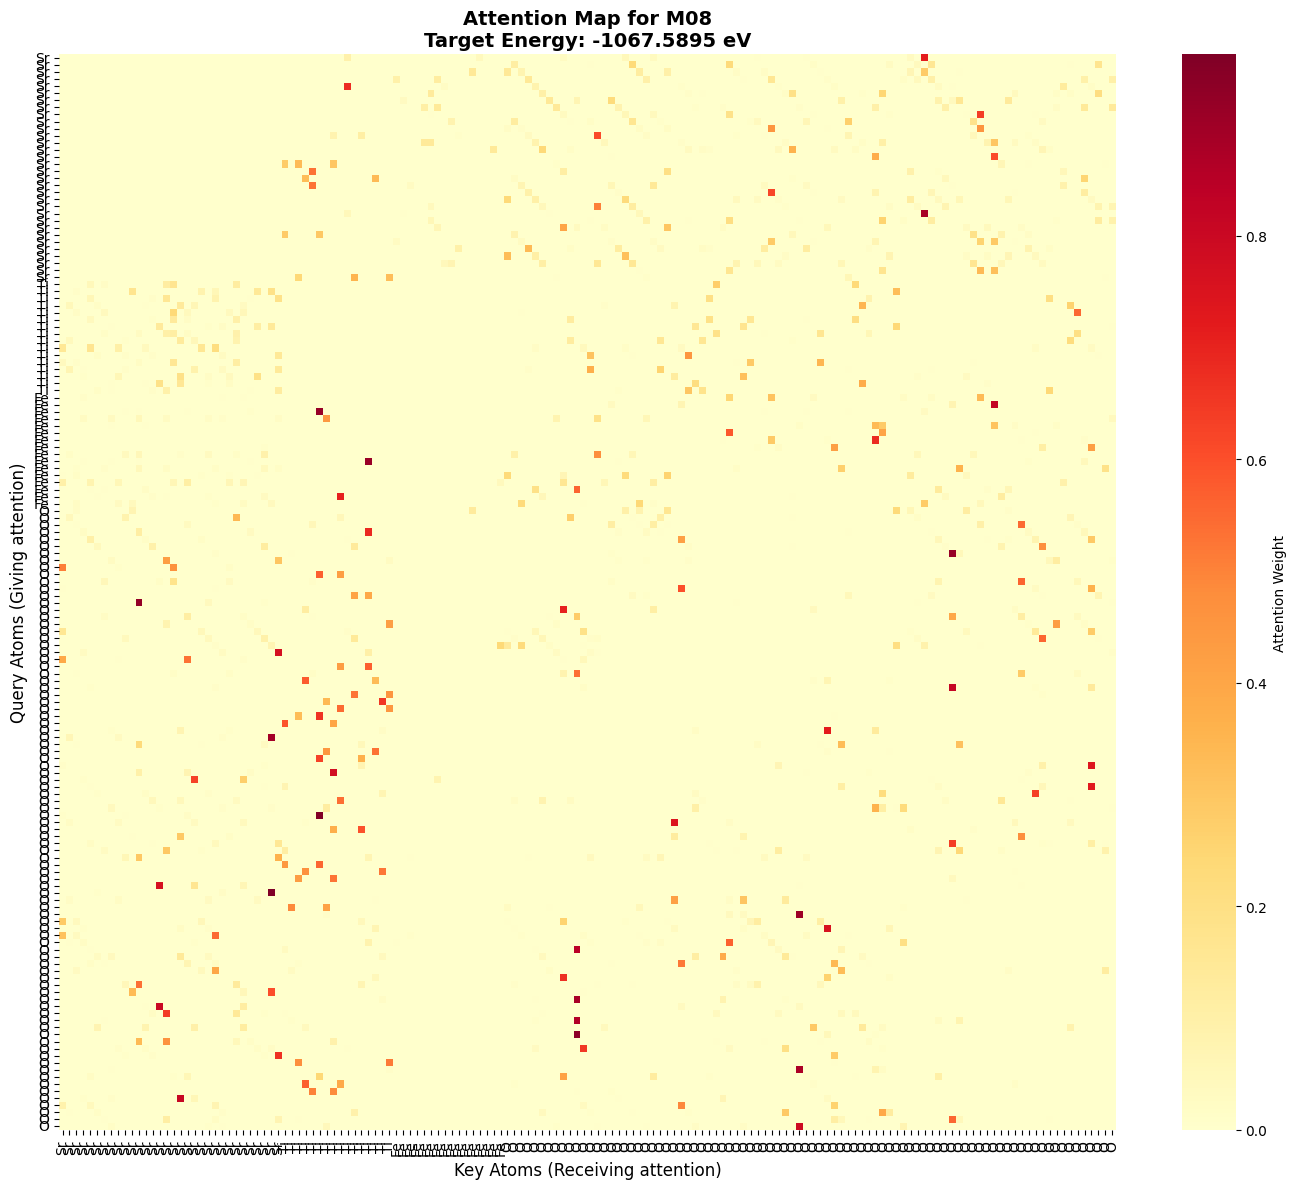

✓ Saved: attention_map_sample_0.png

Top 15 Most Attended Atoms:
Rank   Atom ID    Species    Attention   
1      74         O          0.033021
2      37         Ti         0.031772
3      128        O          0.022928
4      148        O          0.020693
5      40         Ti         0.020353
6      39         Ti         0.019951
7      31         Sr         0.019533
8      72         O          0.019349
9      30         Sr         0.019290
10     44         Ti         0.018481
11     11         Sr         0.018042
12     106        O          0.017452
13     134        O          0.017358
14     15         Sr         0.016854
15     124        O          0.015114


Analyzing sample: B11
Target energy: -1067.4233 eV
Number of atoms: 152



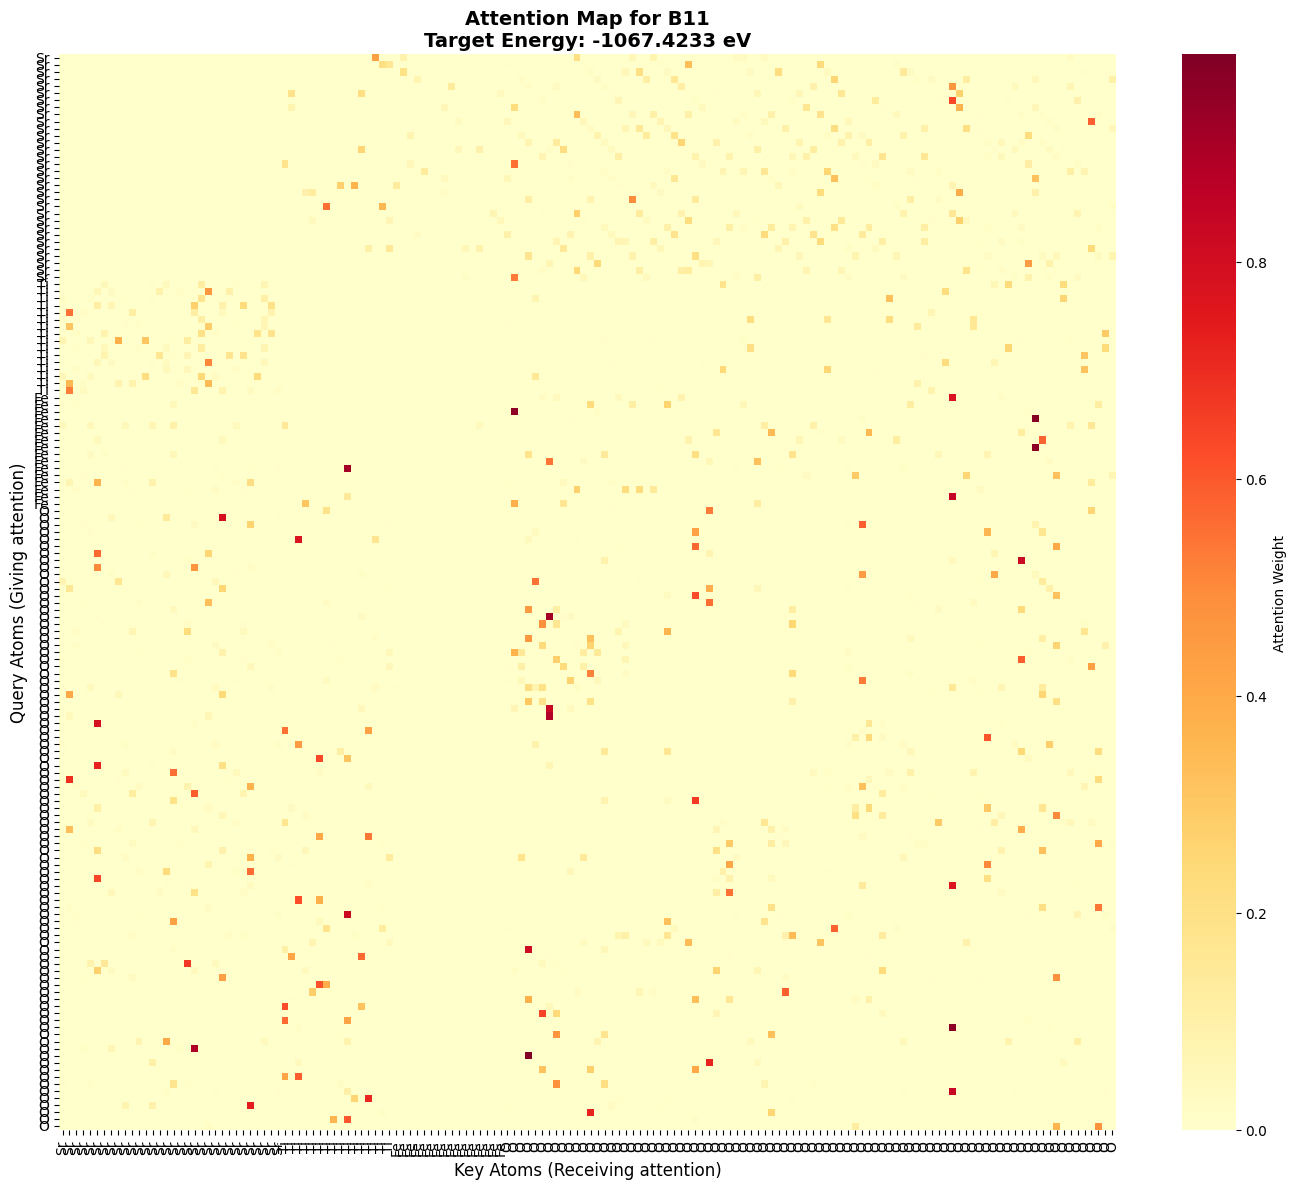

✓ Saved: attention_map_sample_45.png

Top 15 Most Attended Atoms:
Rank   Atom ID    Species    Attention   
1      128        O          0.037632
2      5          Sr         0.029313
3      67         O          0.027859
4      91         O          0.024387
5      1          Sr         0.022711
6      41         Ti         0.022415
7      70         O          0.022308
8      65         O          0.020548
9      143        O          0.019397
10     19         Sr         0.018832
11     76         O          0.018226
12     32         Ti         0.018143
13     27         Sr         0.017702
14     140        O          0.017055
15     138        O          0.016529


Analyzing sample: A06
Target energy: -1066.6827 eV
Number of atoms: 152



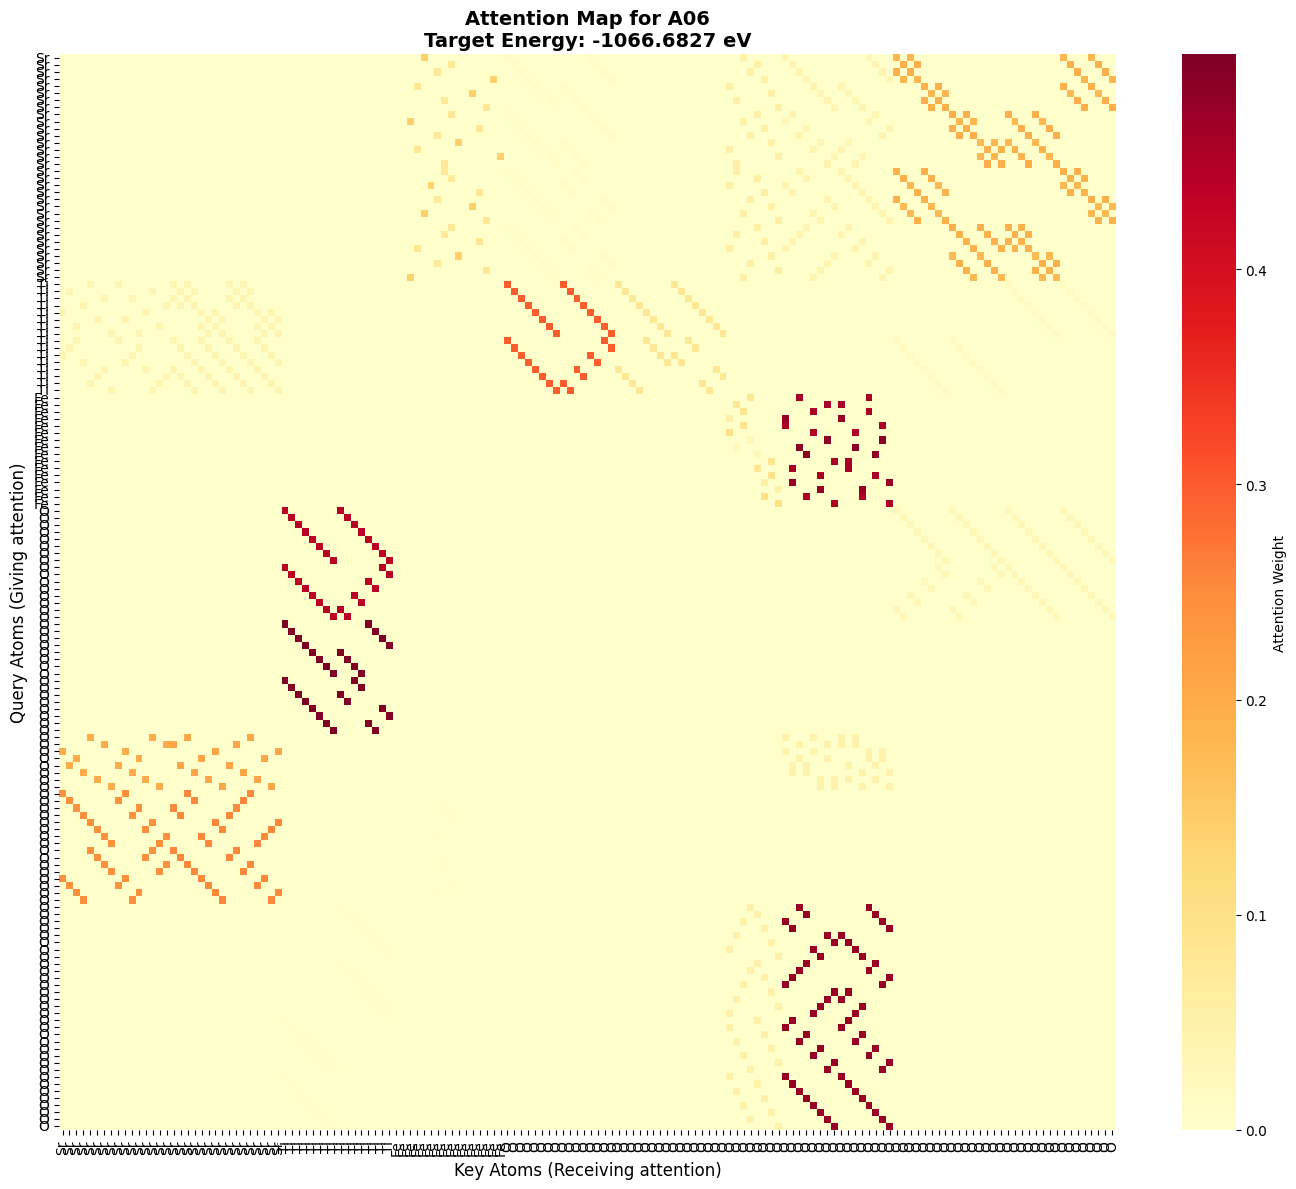

✓ Saved: attention_map_sample_90.png

Top 15 Most Attended Atoms:
Rank   Atom ID    Species    Attention   
1      110        O          0.020289
2      106        O          0.020289
3      118        O          0.020227
4      117        O          0.020227
5      112        O          0.020215
6      105        O          0.020214
7      107        O          0.020206
8      114        O          0.020204
9      109        O          0.020155
10     104        O          0.020139
11     115        O          0.020131
12     119        O          0.020131
13     113        O          0.020058
14     116        O          0.020058
15     108        O          0.019987




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.structure import Structure

def visualize_attention(model, dataset, sample_idx, save_path='attention_map.png'):
    """
    특정 샘플의 attention weights 시각화
    """
    model.eval()

    # 샘플 로드
    (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = dataset[sample_idx]

    print(f"Analyzing sample: {cif_id}")
    print(f"Target energy: {target.item():.4f} eV")
    print(f"Number of atoms: {atom_fea.size(0)}\n")

    # Forward pass
    if torch.cuda.is_available():
        atom_fea_gpu = atom_fea.cuda()
        nbr_fea_gpu = nbr_fea.cuda()
        nbr_fea_idx_gpu = nbr_fea_idx.cuda()
        crystal_atom_idx = [torch.arange(atom_fea.size(0)).cuda()]
    else:
        atom_fea_gpu = atom_fea
        nbr_fea_gpu = nbr_fea
        nbr_fea_idx_gpu = nbr_fea_idx
        crystal_atom_idx = [torch.arange(atom_fea.size(0))]

    with torch.no_grad():
        _ = model(atom_fea_gpu, nbr_fea_gpu, nbr_fea_idx_gpu, crystal_atom_idx)

    # Attention weights 추출 (첫 번째 layer, 첫 번째 head)
    attention_head = model.graphormer_encoder.layers[0].attention.heads[0]
    attn_weights = attention_head.attention_weights.cpu().numpy()

    # 구조 정보
    structure = Structure.from_file(f'./data/Trans_Set_91/{cif_id}.cif')
    species = [str(site.specie) for site in structure]

    # Heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(attn_weights, cmap='YlOrRd',
                xticklabels=species, yticklabels=species,
                cbar_kws={'label': 'Attention Weight'},
                vmin=0, vmax=attn_weights.max())
    ax.set_title(f'Attention Map for {cif_id}\nTarget Energy: {target.item():.4f} eV',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Key Atoms (Receiving attention)', fontsize=12)
    ax.set_ylabel('Query Atoms (Giving attention)', fontsize=12)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {save_path}\n")

    # Top attended atoms
    avg_attention = attn_weights.mean(axis=0)
    top_indices = avg_attention.argsort()[-15:][::-1]

    print(f"Top 15 Most Attended Atoms:")
    print(f"{'Rank':<6} {'Atom ID':<10} {'Species':<10} {'Attention':<12}")
    print("="*50)
    for i, idx in enumerate(top_indices):
        print(f"{i+1:<6} {idx:<10} {species[idx]:<10} {avg_attention[idx]:.6f}")

    return attn_weights, species

# 사용 예시 - 여러 샘플 시각화
print("="*80)
print("ATTENTION WEIGHT VISUALIZATION")
print("="*80 + "\n")

# 예시: 첫 번째, 중간, 마지막 샘플
for idx in [0, len(dataset)//2, len(dataset)-1]:
    attn_weights, species = visualize_attention(
        model, dataset, sample_idx=idx,
        save_path=f'attention_map_sample_{idx}.png'
    )
    print("\n" + "="*80 + "\n")

INTEGRATED GRADIENTS (ATOM IMPORTANCE)

Computing importance for: M08
Target energy: -1067.5895 eV



/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


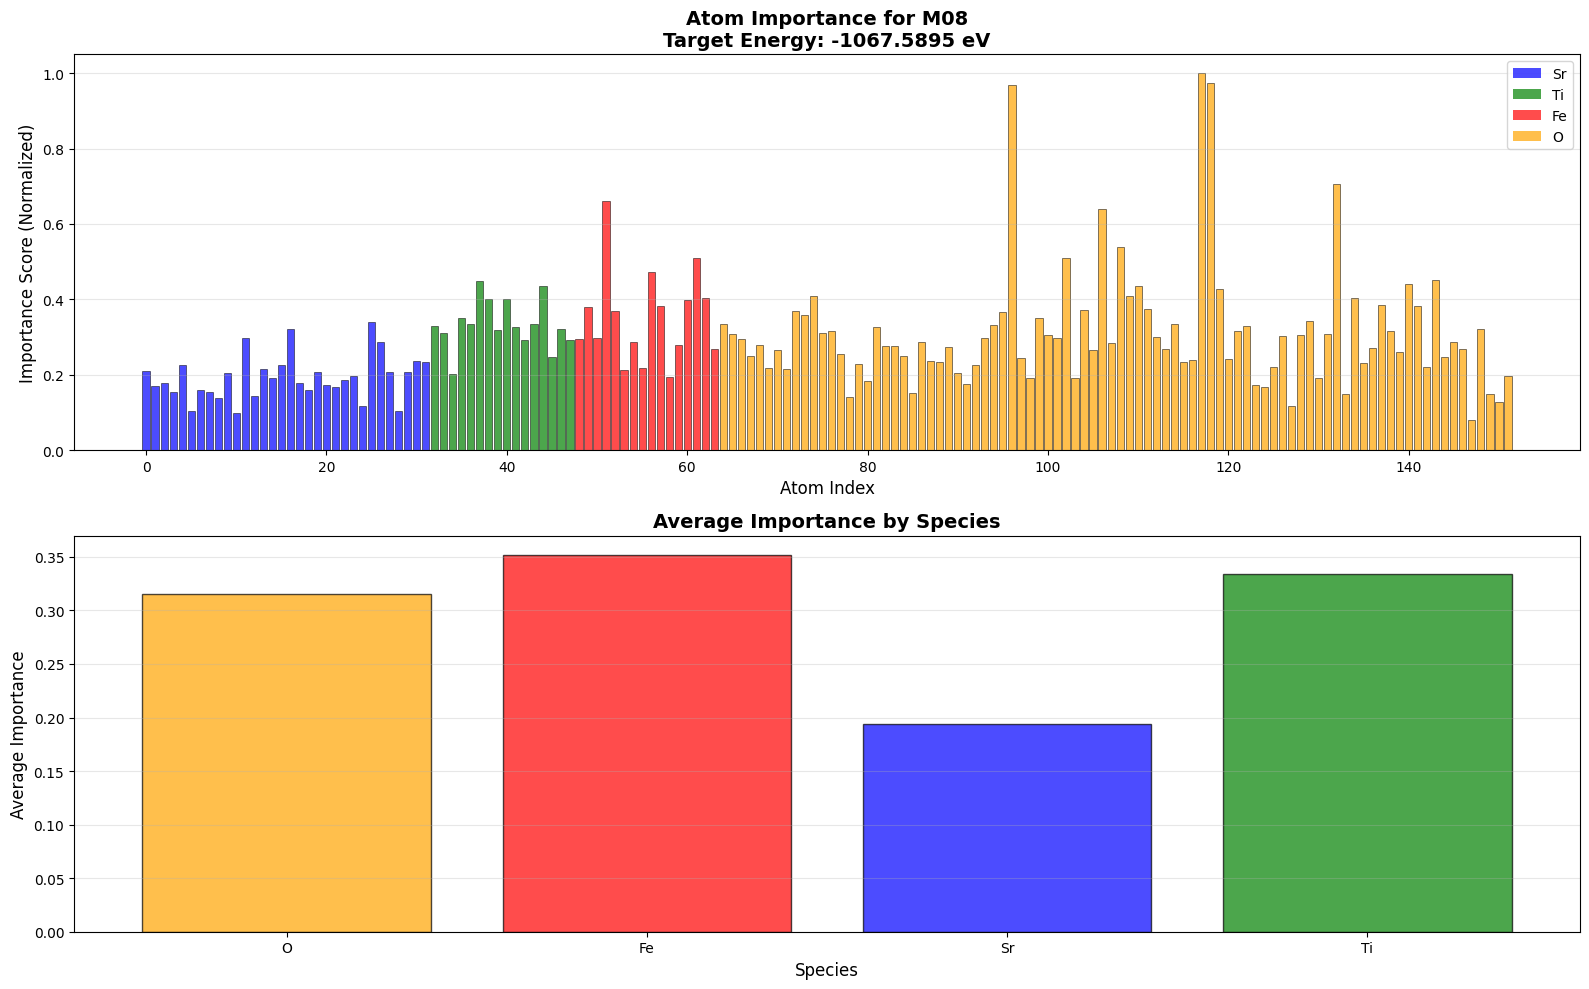

✓ Saved: atom_importance_sample_0.png

Top 15 Most Important Atoms:
Rank   Atom ID    Species    Importance  
1      117        O          1.000000
2      118        O          0.972898
3      96         O          0.969110
4      132        O          0.706021
5      51         Fe         0.660081
6      106        O          0.638837
7      108        O          0.538354
8      102        O          0.510628
9      61         Fe         0.508543
10     56         Fe         0.473434
11     143        O          0.452643
12     37         Ti         0.450005
13     140        O          0.441867
14     44         Ti         0.434605
15     110        O          0.434503

Average Importance by Species:
Species    Avg Importance 
Fe         0.352054
O          0.315085
Sr         0.193718
Ti         0.334322


Computing importance for: B11
Target energy: -1067.4233 eV



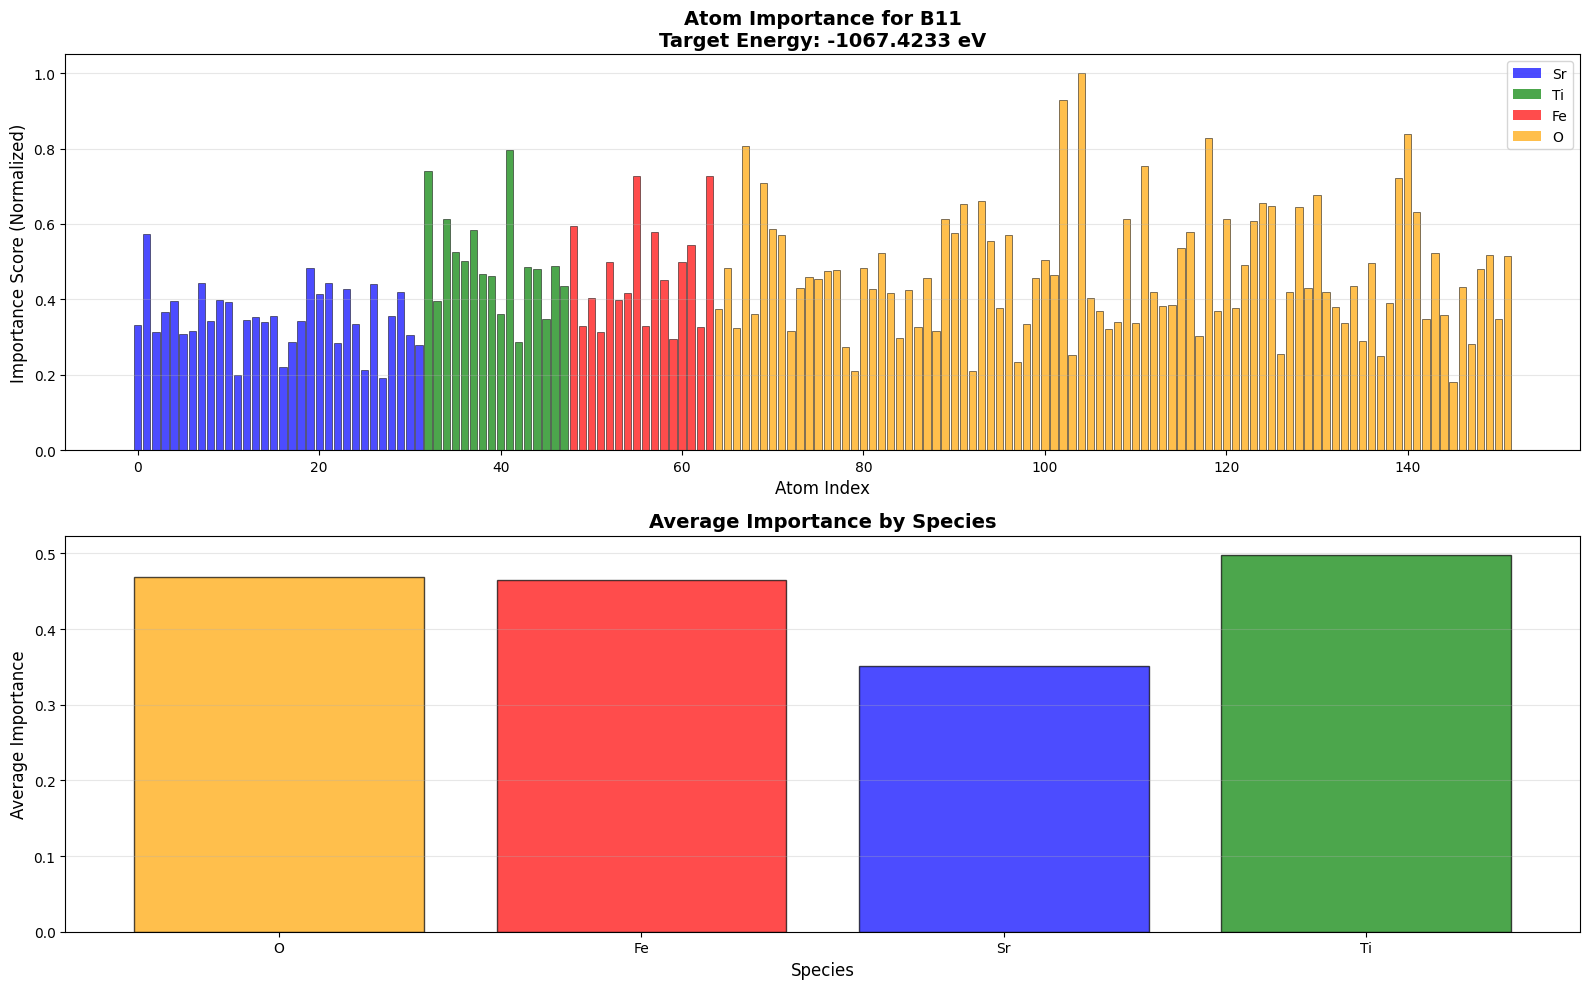

✓ Saved: atom_importance_sample_45.png

Top 15 Most Important Atoms:
Rank   Atom ID    Species    Importance  
1      104        O          1.000000
2      102        O          0.929112
3      140        O          0.839940
4      118        O          0.827497
5      67         O          0.806241
6      41         Ti         0.797203
7      111        O          0.753499
8      32         Ti         0.739601
9      55         Fe         0.728598
10     63         Fe         0.727194
11     139        O          0.721357
12     69         O          0.709850
13     130        O          0.676540
14     93         O          0.661383
15     124        O          0.655939

Average Importance by Species:
Species    Avg Importance 
Fe         0.464908
O          0.469454
Sr         0.350631
Ti         0.498407


Computing importance for: A06
Target energy: -1066.6827 eV



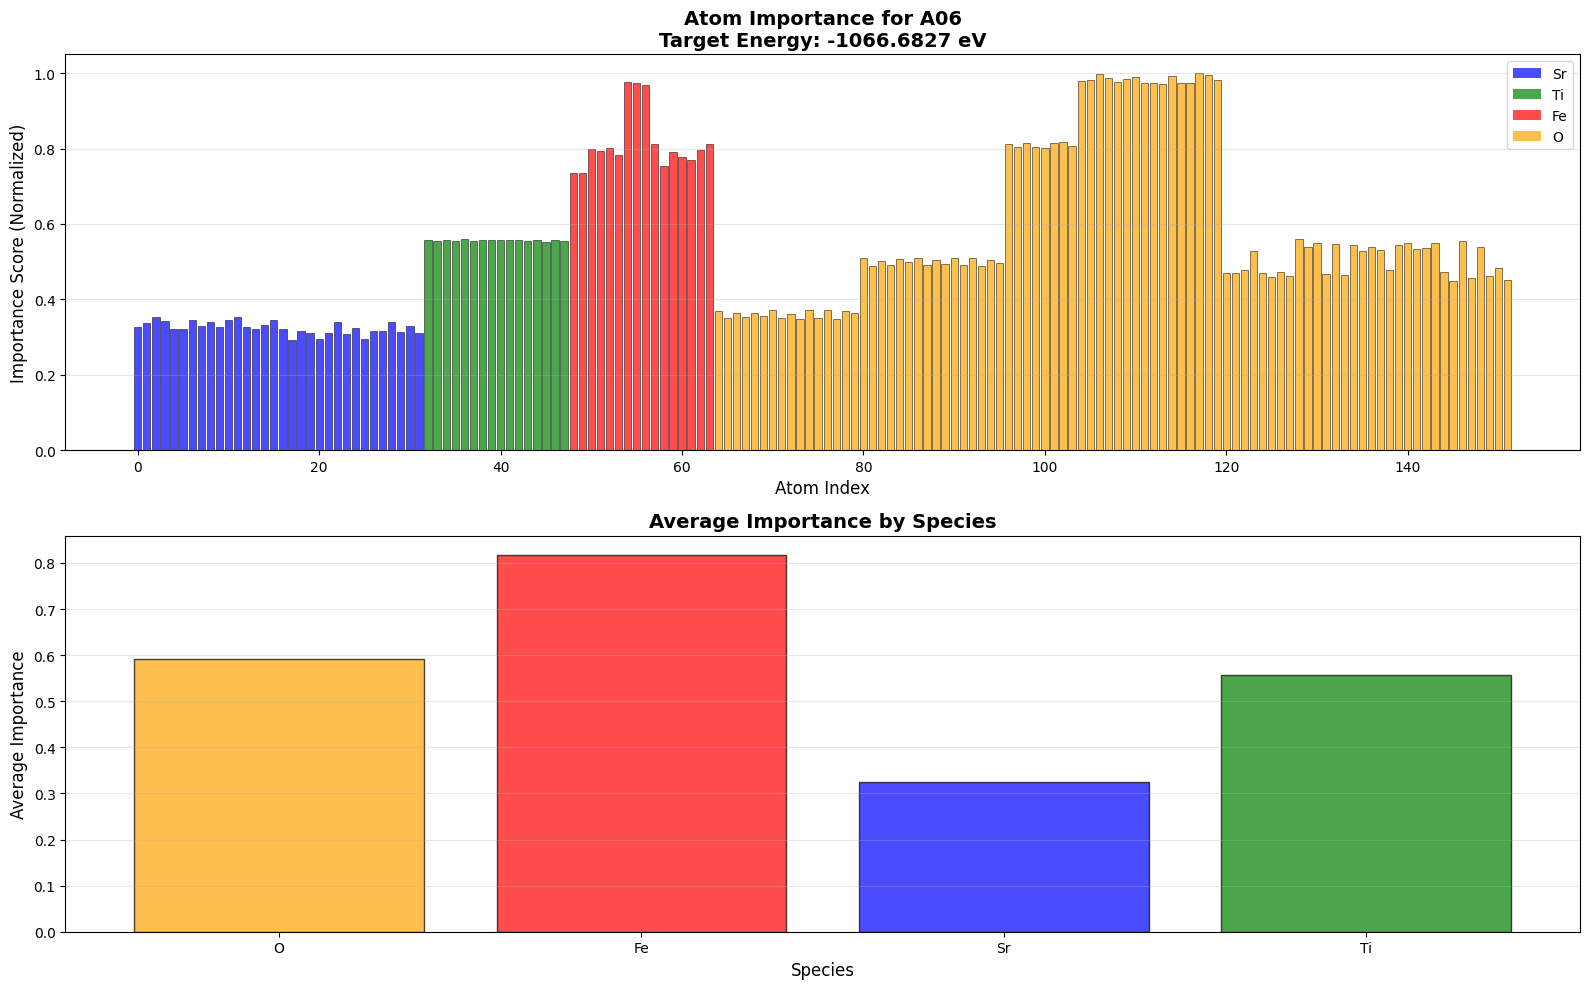

✓ Saved: atom_importance_sample_90.png

Top 15 Most Important Atoms:
Rank   Atom ID    Species    Importance  
1      117        O          1.000000
2      106        O          0.997832
3      118        O          0.996289
4      114        O          0.993077
5      110        O          0.989629
6      107        O          0.986790
7      109        O          0.984187
8      119        O          0.983178
9      105        O          0.982499
10     104        O          0.980358
11     54         Fe         0.977740
12     108        O          0.975771
13     115        O          0.974996
14     112        O          0.973838
15     116        O          0.973688

Average Importance by Species:
Species    Avg Importance 
Fe         0.817853
O          0.592273
Sr         0.325474
Ti         0.556991




In [ ]:
def compute_atom_importance(model, dataset, sample_idx, num_steps=50):
    """
    Integrated Gradients로 각 원자의 중요도 계산
    """
    model.eval()

    # 샘플 로드
    (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = dataset[sample_idx]

    print(f"Computing importance for: {cif_id}")
    print(f"Target energy: {target.item():.4f} eV\n")

    if torch.cuda.is_available():
        atom_fea = atom_fea.cuda()
        nbr_fea = nbr_fea.cuda()
        nbr_fea_idx = nbr_fea_idx.cuda()

    crystal_atom_idx = [torch.arange(atom_fea.size(0), device=atom_fea.device)]

    # Baseline (zeros)
    baseline_atom_fea = torch.zeros_like(atom_fea)

    # Integrated Gradients
    importances = []

    for alpha in torch.linspace(0, 1, num_steps):
        # Interpolate
        interpolated = baseline_atom_fea + alpha * (atom_fea - baseline_atom_fea)
        interpolated = interpolated.detach()
        interpolated.requires_grad = True

        # Forward
        output = model(interpolated, nbr_fea, nbr_fea_idx, crystal_atom_idx)

        # Backward
        model.zero_grad()
        output.sum().backward()

        # Gradient
        grad = interpolated.grad.detach()
        importances.append(grad)

    # Average gradients
    avg_grads = torch.stack(importances).mean(dim=0)

    # Importance = gradient * (input - baseline)
    importance = (atom_fea - baseline_atom_fea) * avg_grads
    atom_importance = importance.abs().sum(dim=1).cpu().numpy()

    # Normalize
    atom_importance = atom_importance / atom_importance.max()

    return atom_importance, cif_id, target.item()

def visualize_atom_importance(dataset, sample_idx, save_path='atom_importance.png'):
    """
    원자별 중요도 시각화
    """
    # Importance 계산
    importance, cif_id, target = compute_atom_importance(model, dataset, sample_idx)

    # 구조 정보
    structure = Structure.from_file(f'./data/Trans_Set_91/{cif_id}.cif')
    species = [str(site.specie) for site in structure]

    # Species별 색상
    species_colors = {
        'Sr': 'blue',
        'Ti': 'green',
        'Fe': 'red',
        'O': 'orange'
    }
    colors = [species_colors.get(s, 'gray') for s in species]

    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    # Bar plot
    bars = ax1.bar(range(len(importance)), importance, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Atom Index', fontsize=12)
    ax1.set_ylabel('Importance Score (Normalized)', fontsize=12)
    ax1.set_title(f'Atom Importance for {cif_id}\nTarget Energy: {target:.4f} eV',
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=spec, alpha=0.7)
                      for spec, color in species_colors.items()]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=10)

    # Species별 평균 importance
    species_importance = {}
    for sp in set(species):
        indices = [i for i, s in enumerate(species) if s == sp]
        species_importance[sp] = importance[indices].mean()

    species_list = list(species_importance.keys())
    importance_list = [species_importance[sp] for sp in species_list]
    colors_list = [species_colors.get(sp, 'gray') for sp in species_list]

    ax2.bar(species_list, importance_list, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1)
    ax2.set_xlabel('Species', fontsize=12)
    ax2.set_ylabel('Average Importance', fontsize=12)
    ax2.set_title('Average Importance by Species', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {save_path}\n")

    # Top important atoms
    top_indices = importance.argsort()[-15:][::-1]

    print(f"Top 15 Most Important Atoms:")
    print(f"{'Rank':<6} {'Atom ID':<10} {'Species':<10} {'Importance':<12}")
    print("="*50)
    for i, idx in enumerate(top_indices):
        print(f"{i+1:<6} {idx:<10} {species[idx]:<10} {importance[idx]:.6f}")

    print(f"\nAverage Importance by Species:")
    print(f"{'Species':<10} {'Avg Importance':<15}")
    print("="*30)
    for sp in sorted(species_importance.keys()):
        print(f"{sp:<10} {species_importance[sp]:.6f}")

    return importance, species

# 사용 예시
print("="*80)
print("INTEGRATED GRADIENTS (ATOM IMPORTANCE)")
print("="*80 + "\n")

for idx in [0, len(dataset)//2, len(dataset)-1]:
    importance, species = visualize_atom_importance(
        dataset, sample_idx=idx,
        save_path=f'atom_importance_sample_{idx}.png'
    )
    print("\n" + "="*80 + "\n")

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def visualize_importance_3d(dataset, sample_idx, importance_scores=None,
                           use_attention=False, save_path='importance_3d.html'):
    """
    Parameters:
    -----------
    dataset: CIFData
    sample_idx: int
    importance_scores: np.array (optional)
        미리 계산된 importance. None이면 자동 계산
    use_attention: bool
        True면 attention weights 사용, False면 Integrated Gradients
    """
    # 샘플 정보
    (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = dataset[sample_idx]
    structure = Structure.from_file(f'./data/Trans_Set_91/{cif_id}.cif')

    # Importance 계산
    if importance_scores is None:
        if use_attention:
            # Attention 사용
            model.eval()
            if torch.cuda.is_available():
                atom_fea_gpu = atom_fea.cuda()
                nbr_fea_gpu = nbr_fea.cuda()
                nbr_fea_idx_gpu = nbr_fea_idx.cuda()
                crystal_atom_idx = [torch.arange(atom_fea.size(0)).cuda()]
            else:
                atom_fea_gpu = atom_fea
                nbr_fea_gpu = nbr_fea
                nbr_fea_idx_gpu = nbr_fea_idx
                crystal_atom_idx = [torch.arange(atom_fea.size(0))]

            with torch.no_grad():
                _ = model(atom_fea_gpu, nbr_fea_gpu, nbr_fea_idx_gpu, crystal_atom_idx)

            attention_head = model.graphormer_encoder.layers[0].attention.heads[0]
            attn_weights = attention_head.attention_weights.cpu().numpy()
            importance_scores = attn_weights.mean(axis=0)
        else:
            # Integrated Gradients
            importance_scores, _, _ = compute_atom_importance(model, dataset, sample_idx)

    # Normalize importance
    importance_norm = (importance_scores - importance_scores.min()) / \
                     (importance_scores.max() - importance_scores.min() + 1e-8)

    # 3D positions (Cartesian coordinates)
    positions = structure.cart_coords
    species = [str(site.specie) for site in structure]

    # Species별 색상 정의
    species_colors = {
        'Sr': 'royalblue',
        'Ti': 'green',
        'Fe': 'red',
        'O': 'orange'
    }

    # Create figure
    fig = go.Figure()

    # Species별로 그룹화하여 plot
    for spec in set(species):
        indices = [i for i, s in enumerate(species) if s == spec]

        spec_positions = positions[indices]
        spec_importance = importance_norm[indices]

        # Marker size: importance에 비례
        sizes = 10 + 30 * spec_importance  # 10~40 범위

        # Hover text
        hover_texts = [
            f"Atom {i}<br>Species: {spec}<br>Importance: {importance_scores[i]:.4f}<br>"
            f"Position: ({positions[i][0]:.2f}, {positions[i][1]:.2f}, {positions[i][2]:.2f})"
            for i in indices
        ]

        fig.add_trace(go.Scatter3d(
            x=spec_positions[:, 0],
            y=spec_positions[:, 1],
            z=spec_positions[:, 2],
            mode='markers',
            marker=dict(
                size=sizes,
                color=spec_importance,
                colorscale='YlOrRd',
                cmin=0,
                cmax=1,
                colorbar=dict(
                    title="Importance",
                    x=1.1
                ) if spec == list(set(species))[0] else None,  # colorbar 한 번만
                line=dict(color=species_colors.get(spec, 'gray'), width=2),
                opacity=0.8
            ),
            text=hover_texts,
            hoverinfo='text',
            name=spec,
            showlegend=True
        ))

    # Bonds 추가 (optional - 가까운 원자들 연결)
    bond_traces = []
    for i in range(len(structure)):
        neighbors = structure.get_neighbors(structure[i], 3.5)  # 3.5 Å cutoff
        for neighbor in neighbors[:6]:  # 최대 6개 이웃만
            j = neighbor.index
            if i < j:  # 중복 방지
                bond_traces.extend([
                    positions[i][0], positions[j][0], None,
                ])

    if bond_traces:
        fig.add_trace(go.Scatter3d(
            x=bond_traces[::3],
            y=bond_traces[1::3],
            z=bond_traces[2::3],
            mode='lines',
            line=dict(color='gray', width=1),
            opacity=0.3,
            showlegend=False,
            hoverinfo='skip'
        ))

    # Layout
    method_name = "Attention Weights" if use_attention else "Integrated Gradients"
    fig.update_layout(
        title=dict(
            text=f'3D Structure with Atom Importance ({method_name})<br>'
                 f'Sample: {cif_id} | Target Energy: {target.item():.4f} eV',
            x=0.5,
            xanchor='center',
            font=dict(size=16)
        ),
        scene=dict(
            xaxis_title='X (Å)',
            yaxis_title='Y (Å)',
            zaxis_title='Z (Å)',
            aspectmode='data',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=1000,
        height=800,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    # Save
    fig.write_html(save_path)
    print(f"✓ Saved: {save_path}")
    print(f"  Open this file in a browser to interact with the 3D structure!\n")

    # Top important atoms 정보
    top_indices = importance_scores.argsort()[-10:][::-1]
    print(f"Top 10 Most Important Atoms:")
    print(f"{'Rank':<6} {'Atom ID':<10} {'Species':<10} {'Importance':<12} {'Position'}")
    print("="*70)
    for rank, idx in enumerate(top_indices):
        pos = positions[idx]
        print(f"{rank+1:<6} {idx:<10} {species[idx]:<10} {importance_scores[idx]:.6f}   "
              f"({pos[0]:.2f}, {pos[1]:.2f}, {pos[2]:.2f})")

    fig.show()
    return fig, importance_scores

# 사용 예시
print("="*80)
print("3D STRUCTURE VISUALIZATION WITH ATOM IMPORTANCE")
print("="*80 + "\n")

# Integrated Gradients 방식
print("Method 1: Integrated Gradients")
print("-"*80)
fig1, imp1 = visualize_importance_3d(
    dataset,
    sample_idx=0,
    use_attention=False,
    save_path='importance_3d_integrated_gradients.html'
)

print("\n" + "="*80 + "\n")

# Attention 방식
print("Method 2: Attention Weights")
print("-"*80)
fig2, imp2 = visualize_importance_3d(
    dataset,
    sample_idx=0,
    use_attention=True,
    save_path='importance_3d_attention.html'
)

print("\n" + "="*80)
print("✓ Visualization complete!")
print("✓ Open the HTML files in your browser to interact with 3D structures")
print("="*80)

3D STRUCTURE VISUALIZATION WITH ATOM IMPORTANCE

Method 1: Integrated Gradients
--------------------------------------------------------------------------------
Computing importance for: M08
Target energy: -1067.5895 eV

✓ Saved: importance_3d_integrated_gradients.html
  Open this file in a browser to interact with the 3D structure!

Top 10 Most Important Atoms:
Rank   Atom ID    Species    Importance   Position
1      117        O          1.000000   (4.23, 7.12, 7.98)
2      118        O          0.972898   (7.01, 4.20, 7.86)
3      96         O          0.969110   (9.85, 4.25, 7.86)
4      132        O          0.706021   (0.04, 5.75, 5.92)
5      51         Fe         0.660081   (8.46, 8.24, 11.64)
6      106        O          0.638837   (7.06, 7.03, 7.77)
7      108        O          0.538354   (1.43, 4.11, 7.73)
8      102        O          0.510628   (1.46, 7.02, 8.09)
9      61         Fe         0.508543   (5.72, 11.20, 3.97)
10     56         Fe         0.473434   (11.15, 0.2



Method 2: Attention Weights
--------------------------------------------------------------------------------
✓ Saved: importance_3d_attention.html
  Open this file in a browser to interact with the 3D structure!

Top 10 Most Important Atoms:
Rank   Atom ID    Species    Importance   Position
1      74         O          0.033021   (4.22, 9.88, 3.94)
2      37         Ti         0.031772   (2.89, 2.81, 0.05)
3      128        O          0.022928   (5.61, 5.67, 1.95)
4      148        O          0.020693   (8.59, 2.88, 1.85)
5      40         Ti         0.020353   (2.76, 2.87, 11.82)
6      39         Ti         0.019951   (2.79, 8.53, 15.82)
7      31         Sr         0.019533   (8.37, 5.55, 13.76)
8      72         O          0.019349   (1.33, 1.43, 3.83)
9      30         Sr         0.019290   (8.52, 5.59, 5.99)
10     44         Ti         0.018481   (11.23, 5.60, 11.80)



✓ Visualization complete!
✓ Open the HTML files in your browser to interact with 3D structures
